In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData
import seaborn as sns
sns.set_style("whitegrid")

In [22]:
#reduced chi2 calculations
def redchi2(f, x, y, y_err, *args):
    sum = 0
    for i in range(len(x)):
        sum += np.square((f(x[i], *args) - y[i])/(y_err[i]))
    dof = len(y) - len(args)
    rc2 = np.sqrt(sum)/dof
    return rc2

In [23]:
#coeff of determination: R^2
def R2(f, x, y, y_err, *args):
    ybar=np.mean(y)
    ss_tot = np.sum((y-ybar)**2)
    ss_res = np.sum((y-f(x, *args))**2)
    Rsq = 1-(ss_res/ss_tot)
    return Rsq

In [24]:
df = pd.read_csv('../data/unattpowvsattpow.csv',delimiter=',', header=0)
#read all columns data into variables
current = np.array(df['I (mA)'])
current_error = np.array(df['delta I'])
unatt_pow = np.array(df['Pnoatt [muW]'])
unatt_pow_error = np.array(df['delta Pnoatt'])
att_pow = np.array(df['Patt [muW]'])
att_pow_error = np.array(df['delta Patt'])

## Calibration of Attenuator

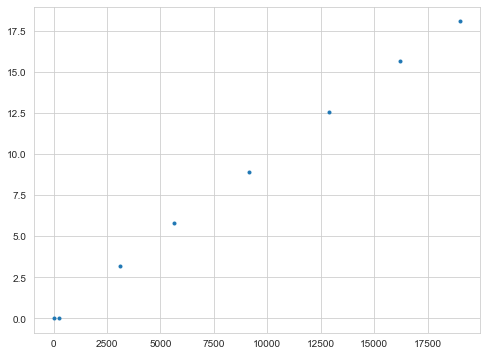

In [25]:
#Slicing req values
unatt_pow_cut = unatt_pow[(unatt_pow>=28.2) & (unatt_pow<=19000)]
att_pow_cut = att_pow[(unatt_pow>=28.2) & (unatt_pow<=19000)]
unatt_pow_error_cut = unatt_pow_error[(unatt_pow>=28.2) & (unatt_pow<=19000)]
att_pow_error_cut = att_pow_error[(unatt_pow>=28.2) & (unatt_pow<=19000)]
plt.figure(figsize=(8, 6))
plt.plot(unatt_pow_cut, att_pow_cut,'.')
plt.show()

### Model for linear fit of attenuated power vs unattenuated power:

$P_{att}=aP_{unatt}+b$

In [26]:
def linear_model(x, a, b):
    return (a*x+b)

In [27]:
#Fit curve using some guess values for a and b
#popt stores optimal parameters
'''
pcov stores covariance matrix
Diagonal entries of cov matrix are variances of fit parameters
Sqrt(diag(pcov)) will give error (std dev) of fit paramaters
'''
popt, pcov = curve_fit(linear_model, unatt_pow_cut, att_pow_cut, sigma = att_pow_error_cut, p0=[1/1000,0], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print("Optimal parameters:","a=",popt[0],"b=",popt[1])
print("Errors in optimal parameters:","delta_a=",perr[0],"delta_b=",perr[1])


Optimal parameters: a= 0.0009947484183711964 b= -0.01635953514068112
Errors in optimal parameters: delta_a= 1.252530749933867e-06 delta_b= 0.006436979200177107


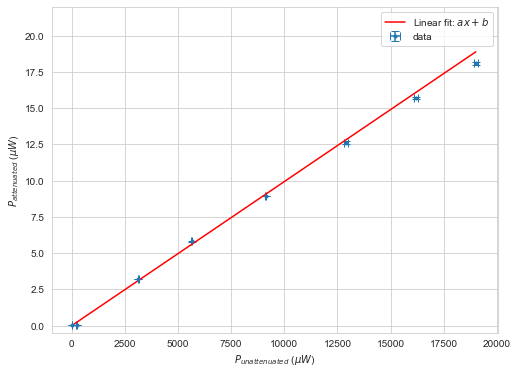

In [37]:
a_opt, b_opt = popt
x_model = np.linspace(min(unatt_pow_cut), max(unatt_pow_cut), 1000)
y_model = linear_model(x_model, a_opt, b_opt)
plt.figure(figsize=(8, 6))
plt.ylim(-0.5, 22)
plt.xlabel(r"$P_{unattenuated}$ ($\mu W$)")
plt.ylabel(r"$P_{attenuated}$ ($\mu W$)")
plt.errorbar(unatt_pow_cut, att_pow_cut, yerr = att_pow_error_cut, xerr = unatt_pow_error_cut, fmt = ".", label = 'data', capsize = 4)
plt.plot(x_model, y_model, color='r', label= r"Linear fit: $ax+b$")
plt.legend(loc = 'upper right')
plt.show()

In [29]:
print(redchi2(linear_model, unatt_pow_cut, att_pow_cut, att_pow_error_cut, popt[0], popt[1]))

5.39584784205584


In [30]:
print(R2(linear_model, unatt_pow_cut, att_pow_cut, att_pow_error_cut, popt[0], popt[1]))

0.9972889507581929
